In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

#metrics
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc


%matplotlib inline

In [2]:
df_math = pd.read_csv('student-mat.csv')
df_port = pd.read_csv('student-por.csv')


In [3]:
cat_data = pd.get_dummies(df_port[['school', 'sex','address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']],drop_first=True)
nominal_cat = pd.get_dummies(df_port[['Mjob','Fjob','reason','guardian']],drop_first=True)
numeric_data = df_port[['age','Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health','absences','failures']]

In [4]:
grades = pd.DataFrame()
#pass = 1, fail = 0
def passfail(grade):
    if grade >=10:
        return 0
    if grade <10:
        return 1
grades['G1'] = df_port['G1'].apply(passfail)
grades['G2'] = df_port['G2'].apply(passfail)
grades['G3'] = df_port['G3'].apply(passfail)

In [7]:
df_pre = pd.concat([grades, cat_data,numeric_data, nominal_cat], axis = 1)
df_pre.columns

Index(['G1', 'G2', 'G3', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3',
       'Pstatus_T', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes', 'age', 'Medu', 'Fedu', 'traveltime', 'studytime',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'failures', 'Mjob_health', 'Mjob_other', 'Mjob_services',
       'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services',
       'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'guardian_mother', 'guardian_other'],
      dtype='object')

In [30]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE
X = df_pre.drop(['G1','G2','G3'], axis =1)
y = df_pre['G1']

model = LogisticRegression()
# create the RFE model and select 50 features
rfe = RFE(model, 20)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
selected_features_ranking = list(zip(X.columns,rfe.support_,rfe.ranking_))

In [31]:
#create a new dataframe with only features selected by RFE
selected_features = [i[0] for i in selected_features_ranking if i[1] == True]
selected_features_df = pd.DataFrame()
for i in selected_features:
    selected_features_df[i] = df_pre[i]

In [32]:
df = pd.merge(df_pre[['G1']].reset_index(), selected_features_df.reset_index(), on = 'index', how='inner').set_index('index')
df.dropna(inplace=True)

In [33]:
df.columns

Index(['G1', 'school_MS', 'sex_M', 'famsize_LE3', 'schoolsup_yes', 'paid_yes',
       'activities_yes', 'higher_yes', 'studytime', 'freetime', 'Dalc',
       'failures', 'Mjob_services', 'Mjob_teacher', 'Fjob_health',
       'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
       'guardian_mother', 'guardian_other'],
      dtype='object')

## Train/Test Split

In [34]:
X = df.drop(['G1'], axis = 1)
y = df['G1']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### with normalization

In [36]:
normalizer = preprocessing.Normalizer()
X_norm = normalizer.fit_transform(X)

In [37]:
X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

## Models Comparison

In [42]:
Cs = np.logspace(-4., 4., 30)
models = [LogisticRegressionCV(cv=10, Cs = Cs),
          GaussianNB(),
          RandomForestClassifier(max_depth=15, n_estimators=18),
          GradientBoostingClassifier(learning_rate = 0.01, max_depth = 5, min_samples_split = 9)]

model_names = ['Logistic', 'Naive Bayes','Random Forest','Gradient Boosting']

In [47]:
accuracy = []
cutoff_accuracy = []
precision_pass = []
precision_fail = []
recall_pass = []
recall_fail = []
f1_pass = []
f1_fail = []
auc = []
threshold = 0.3

## Go through the models and find the scores
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    #predict with custom threshold
    y_pred_cutoff = np.where(y_pred_prob >= threshold, 1, 0)
    
    cutoff_accuracy.append( accuracy_score(y_test, y_pred_cutoff) )
    accuracy.append( accuracy_score(y_test, y_pred) )
    
    precision_pass.append( precision_score(y_test, y_pred_cutoff, pos_label=0) )
    precision_fail.append( precision_score(y_test, y_pred_cutoff, pos_label=1) )
    recall_pass.append( recall_score(y_test, y_pred_cutoff, pos_label=0))
    recall_fail.append( recall_score(y_test, y_pred_cutoff, pos_label=1))
    f1_pass.append( f1_score(y_test, y_pred_cutoff, pos_label=0) )
    f1_fail.append( f1_score(y_test, y_pred_cutoff, pos_label=1) )
    auc.append(roc_auc_score(y_test, y_pred_prob))
    print (confusion_matrix(y_test,y_pred_cutoff))

accuracy_df = pd.DataFrame({'accuracy':accuracy, 'auc':auc, 'precision-pass':precision_pass, 'precision-fail':precision_fail,
                            'recall-pass':recall_pass, 'recall-fail':recall_fail, 'f1-pass':f1_pass, 'f1-fail':f1_fail})
accuracy_df.set_index([model_names])

[[147  19]
 [ 23  26]]
[[142  24]
 [ 23  26]]
[[137  29]
 [ 21  28]]
[[137  29]
 [ 15  34]]


,accuracy,auc,f1-fail,f1-pass,precision-fail,precision-pass,recall-fail,recall-pass
Logistic,0.823256,0.824195,0.553191,0.875000,0.577778,0.864706,0.530612,0.885542
Naive Bayes,0.804651,0.793275,0.525253,0.858006,0.520000,0.860606,0.530612,0.855422
Random Forest,0.781395,0.773728,0.528302,0.845679,0.491228,0.867089,0.571429,0.825301
Gradient Boosting,0.809302,0.790140,0.607143,0.861635,0.539683,0.901316,0.693878,0.825301


### ROC Curve

In [50]:
## Calc and store each ROC and AUC
fpr_list = []
tpr_list = []
auc_list = []
for model in models:
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))
    
for model in models_norm:
    y_pred_prob = model.predict_proba(X_test_norm)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(metrics.auc(fpr, tpr))

IndexError: list index out of range

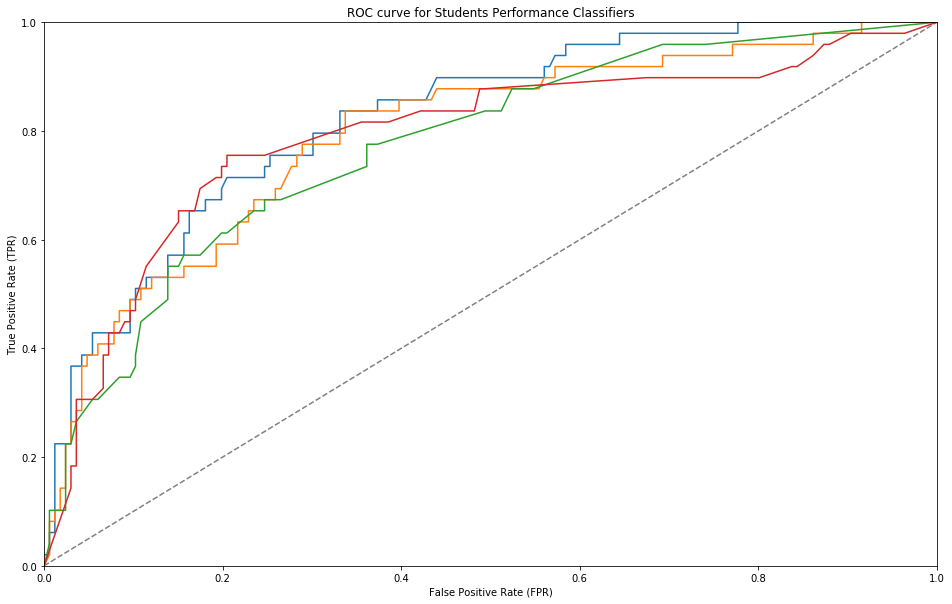

In [51]:
## Plot them all on 1 graph
plt.figure(figsize=(16,10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC curve for Students Performance Classifiers')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], label = model_names[i] + ' - AUC: ' + str(auc_list[i]))
plt.legend(loc = 0, fontsize = 15)